/root/miniconda/envs/r1v/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading checkpoint shards: 100%|██████████| 2/2 [00:07<00:00,  3.50s/it]


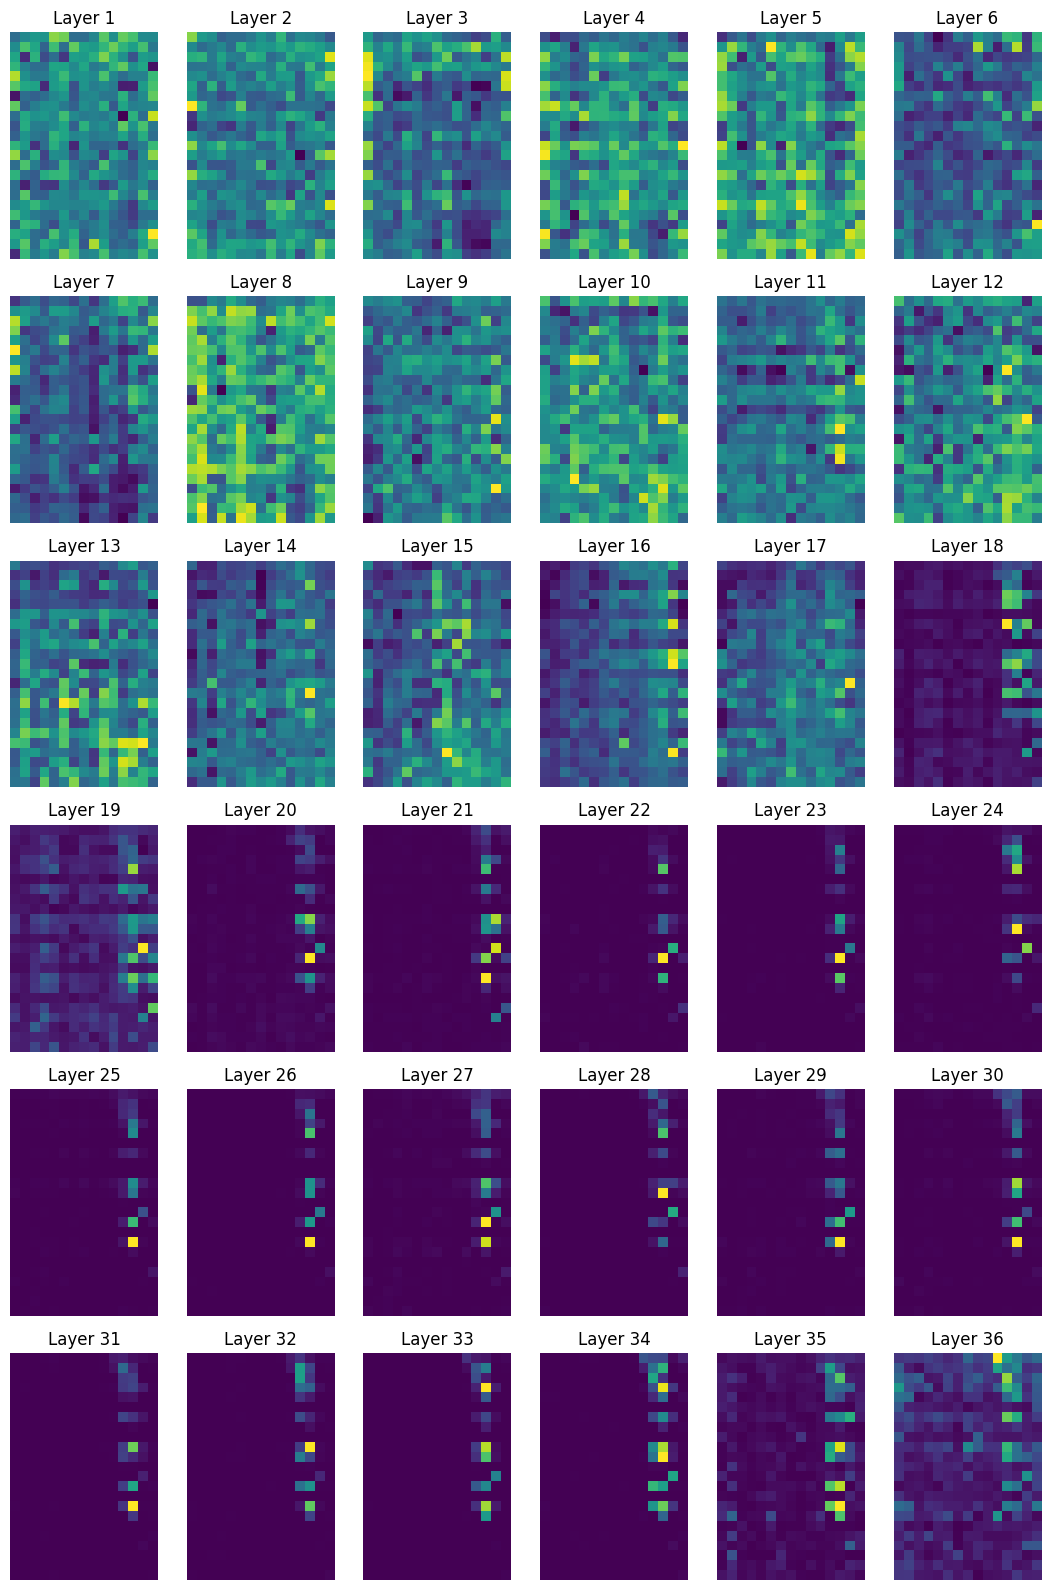

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoProcessor
import torch
import matplotlib.pyplot as plt
from qwen_vl_utils import process_vision_info
import math 

def calculate_plt_size(attention_layer_num):    
    num_layers = attention_layer_num
    cols = math.ceil(math.sqrt(num_layers))  
    rows = math.ceil(num_layers / cols)     
    return rows, cols

device = 'cuda'
model_path = '/home/user/R1-V/data/Qwen25-VL-3B-Instruct-SFT'

model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
                model_path,
                torch_dtype=torch.bfloat16,
                attn_implementation="eager",
            ).eval().to(device)
processor = AutoProcessor.from_pretrained(model_path, trust_remote_code=True, padding_side='left', use_fast=True)

image_path = './image.png'
question = 'what is the date of the photo?'

messages_query = [
    {
        "role": "user",
        "content": [
            {"type": "image", "image": image_path, "max_pixels": 512*28*28},
            {"type": "text", "text": f"{question} Answer the question using a single word or phrase."},
        ],
    }
]

image_inputs, _ = process_vision_info(messages_query)

text_query = processor.apply_chat_template(
    messages_query,
    tokenize=False,
    add_generation_prompt=True
)

inputs = processor(
    text=[text_query],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to(device)

messages_general = [
    {
        "role": "user",
        "content": [
            {"type": "image","image": image_path,"max_pixels": 512*28*28},
            {"type": "text", "text": "Write a general description of the image. Answer the question using a single word or phrase."},
        ],
    }
]

text_general = processor.apply_chat_template(
    messages_general,
    tokenize=False,
    add_generation_prompt=True
)

general_inputs = processor(
    text=[text_general],
    images=image_inputs,
    padding=True,
    return_tensors="pt",
).to(device)

image_inputs_aux = processor.image_processor(images=image_inputs)
output_shape = image_inputs_aux["image_grid_thw"].squeeze(0)[1:]/2
output_shape = output_shape.astype(int)

with torch.no_grad():
    vision_start_token_id = processor.tokenizer.convert_tokens_to_ids('<|vision_start|>')
    vision_end_token_id = processor.tokenizer.convert_tokens_to_ids('<|vision_end|>')
    pos = inputs['input_ids'].tolist()[0].index(vision_start_token_id) + 1
    pos_end = inputs['input_ids'].tolist()[0].index(vision_end_token_id)

    output = model(**inputs, output_attentions=True)
    general_output = model(**general_inputs, output_attentions=True)
    rows, cols = calculate_plt_size(len(output.attentions))
    fig, axes = plt.subplots(rows, cols, figsize=(10.8, 16))
    for i, ax in enumerate(axes.flatten()):
        if i < len(output.attentions): 
            att = output.attentions[i][0, :, -1, pos:pos_end].mean(dim=0)
            att = att.to(torch.float32).detach().cpu().numpy()

            general_att = general_output.attentions[i][0, :, -1, pos:pos_end].mean(dim=0)
            general_att = general_att.to(torch.float32).detach().cpu().numpy()

            att = att / general_att

            ax.imshow(att.reshape(output_shape), cmap="viridis", interpolation="nearest")
            ax.set_title(f"Layer {i+1}")
            ax.axis("off")
        else:
            ax.axis("off")

    plt.tight_layout()    
    plt.show()    

In [ ]:
from transformers import Qwen2_5_VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info


device = 'cuda'
# default: Load the model on the available device(s)
model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
    "/home/user/R1-V/data/Qwen25-VL-3B-Instruct-SFT", torch_dtype="auto"
).to(device)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2_5_VLForConditionalGeneration.from_pretrained(
#     "/root/R1-V/src/r1-v/output_nothink/checkpoint-200",
#     torch_dtype='auto',
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384.
# You can set min_pixels and max_pixels according to your needs, such as a token range of 256-1280, to balance performance and cost.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2.5-VL-3B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to(device)

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


In [2]:
from transformers import Qwen2VLForConditionalGeneration, AutoTokenizer, AutoProcessor
from qwen_vl_utils import process_vision_info

# default: Load the model on the available device(s)
model = Qwen2VLForConditionalGeneration.from_pretrained(
    "/home/user/R1-V/data/Qwen25-VL-3B-Instruct-SFT", torch_dtype="auto", device_map="auto"
)

# We recommend enabling flash_attention_2 for better acceleration and memory saving, especially in multi-image and video scenarios.
# model = Qwen2VLForConditionalGeneration.from_pretrained(
#     "Qwen/Qwen2-VL-7B-Instruct",
#     torch_dtype=torch.bfloat16,
#     attn_implementation="flash_attention_2",
#     device_map="auto",
# )

# default processer
processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct")

# The default range for the number of visual tokens per image in the model is 4-16384. You can set min_pixels and max_pixels according to your needs, such as a token count range of 256-1280, to balance speed and memory usage.
# min_pixels = 256*28*28
# max_pixels = 1280*28*28
# processor = AutoProcessor.from_pretrained("Qwen/Qwen2-VL-7B-Instruct", min_pixels=min_pixels, max_pixels=max_pixels)

messages = [
    {
        "role": "user",
        "content": [
            {
                "type": "image",
                "image": "https://qianwen-res.oss-cn-beijing.aliyuncs.com/Qwen-VL/assets/demo.jpeg",
            },
            {"type": "text", "text": "Describe this image."},
        ],
    }
]

# Preparation for inference
text = processor.apply_chat_template(
    messages, tokenize=False, add_generation_prompt=True
)
image_inputs, video_inputs = process_vision_info(messages)
inputs = processor(
    text=[text],
    images=image_inputs,
    videos=video_inputs,
    padding=True,
    return_tensors="pt",
)
inputs = inputs.to("cuda")

# Inference: Generation of the output
generated_ids = model.generate(**inputs, max_new_tokens=128)
generated_ids_trimmed = [
    out_ids[len(in_ids) :] for in_ids, out_ids in zip(inputs.input_ids, generated_ids)
]
output_text = processor.batch_decode(
    generated_ids_trimmed, skip_special_tokens=True, clean_up_tokenization_spaces=False
)
print(output_text)


Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.48, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


["The image depicts a serene beach scene with a woman and a dog. The woman, sitting on the sand, is wearing a plaid shirt and appears to be smiling. The dog, which is a large breed, is sitting next to her, with its front paws raised in a high-five gesture. The dog is wearing a harness, and the woman is holding the dog's paw. The background shows the ocean with gentle waves, and the sky is clear, suggesting a bright and sunny day. The lighting in the image is warm, indicating either sunrise or sunset. The overall atmosphere is peaceful and joyful, capturing a moment of connection between"]


In [ ]:
import math

def count_reward(y_true: int, y_pred: int,
                 a: float = 1.0, b: float = 0.3,
                 p: float = 2.0, c: float = 6.5,
                 a0: float = 1.0, delta: float = 0.0) -> float:
    e = abs(y_pred - y_true)  # absolute error
    scale = a + b * y_true
    base = (e / scale) ** p if scale > 0 else float('inf')

    small_y_factor = 1.0 + c / (y_true + a0)
    undercount_factor = 1.0 + (delta if y_pred < y_true else 0.0)

    exponent = base * small_y_factor * undercount_factor
    reward = math.exp(-exponent)
    return reward